In [7]:
import torch
from torch import nn
from dltool import dataprocess, train

# 从0实现BN层

In [8]:
# gamma和beta是可以学习的
# moving_*是全局的变量，momentum是更新moving_*用的
# eps是公式一部分，少了效果就不好了，玄学
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
  # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
  if not torch.is_grad_enabled():
    #预测模式，直接使用传入的移动平均所得到的均值和方差
    X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
  else:
    assert len(X.shape) in (2,4)
    if len(X.shape) == 2:
      # 使用全连接层，计算特征维上的均值和方差
      mean = X.mean(dim=0)
      var = ((X-mean) ** 2).mean(dim=0)
    else:
      # 二维卷积层，计算通道维上的均值和方差
      # 0: batch样本 2,3：一个样本的宽高
      # 输出1 * n * 1 * 1的特征矩阵，保留通道维度
      mean = X.mean(dim=(0,2,3),keepdim=True)
      var = ((X-mean) ** 2).mean(dim=(0,2,3),keepdim=True)
    #训练模式下，用当前的均值和方差做标准化
    X_hat = (X - mean) / torch.sqrt(var + eps)
    # 更新移动平均的均值和方差
    moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
    moving_var = momentum * moving_var + (1.0 - momentum) * var
  Y = gamma * X_hat + beta # 缩放和移位
  return Y, moving_mean.data, moving_var.data

In [9]:
class BatchNorm(nn.Module):
  # num_features: 完全连接层的输出数量或卷积层的输出通道数
  # num_dims: 2表示完全连接层，4表示卷积层
  def __init__(self, num_features, num_dims):
    super().__init__()
    if num_dims == 2:
      shape = (1,num_features)
    else:
      shape = (1,num_features,1,1)
    # 参与求梯度和迭代的拉伸和偏移参数，分别初始化为1和0
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))
    # 非模型参数的变量初始化为0和1
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)
  
  def forward(self, X):
    # 如果X不在内存中，将moving_mean和moving_var复制到X所在显存
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)
    # 保存更新后的moving_*
    Y,self.moving_mean,self.moving_var = batch_norm(
      X,self.gamma,self.beta,self.moving_mean,self.moving_var,
      eps=1e-5,momentum=0.9
    )
    return Y

# 使用BN层的LeNet

In [10]:
net = nn.Sequential(
  nn.Conv2d(1,6,kernel_size=5), BatchNorm(6,num_dims=4),nn.Sigmoid(),
  nn.AvgPool2d(kernel_size=2, stride=2),
  nn.Conv2d(6,16,kernel_size=5),BatchNorm(16,num_dims=4),nn.Sigmoid(),
  nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
  nn.Linear(16*4*4,120),BatchNorm(120,num_dims=2),nn.Sigmoid(),
  nn.Linear(120,84),BatchNorm(84,num_dims=2),nn.Sigmoid(),
  nn.Linear(84,10)
)

loss 0.271, train acc 0.900, test acc  0.812
cuda:0


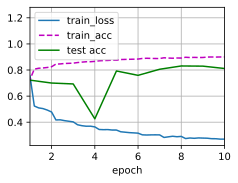

In [11]:
lr , num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = dataprocess.load_data_fashion_mnist(batch_size)
train.train_GPU(net, train_iter, test_iter, num_epochs, lr, train.try_gpu())

In [12]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.7596, 2.4556, 4.3802, 2.6452, 0.5092, 1.4606], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-1.1562,  2.7763,  2.4229,  2.3290,  1.3111,  1.9992], device='cuda:0',
        grad_fn=<ViewBackward0>))

# API实现BN层

In [15]:
net = nn.Sequential(
  nn.Conv2d(1,6,kernel_size=5), nn.BatchNorm2d(6),nn.Sigmoid(),
  nn.AvgPool2d(kernel_size=2, stride=2),
  nn.Conv2d(6,16,kernel_size=5),nn.BatchNorm2d(16),nn.Sigmoid(),
  nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
  nn.Linear(16*4*4,120),nn.BatchNorm1d(120),nn.Sigmoid(),
  nn.Linear(120,84),nn.BatchNorm1d(84),nn.Sigmoid(),
  nn.Linear(84,10)
)

loss 0.267, train acc 0.900, test acc  0.774
cuda:0


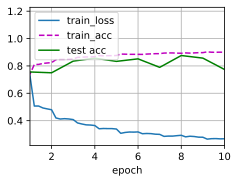

In [16]:
lr , num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = dataprocess.load_data_fashion_mnist(batch_size)
train.train_GPU(net, train_iter, test_iter, num_epochs, lr, train.try_gpu())